Import necessary libaries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from collections import Counter
from wordcloud import WordCloud
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pre-Processing

In [26]:
#Read csv files
train_data = pd.read_csv('./Data/train_set.csv')
test_data = pd.read_csv('./Data/test_set.csv')

#Create Dataframes
train_set = pd.DataFrame(train_data)
test_set = pd.DataFrame(test_data)

#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=['Party'])

#Make all text lowercase
train_set['Text'] = train_set['Text'].str.lower()
test_set['Text'] = test_set['Text'].str.lower()

#Remove accents from all text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents)
test_set['Text'] = test_set['Text'].apply(remove_accents)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)


Save Pre Processed Dataframe

In [27]:
train_set.to_csv('processed_df',index=False)
test_set.to_csv('processed_test',index=False)

Read Pre Processed Dataframe

In [28]:
data = pd.read_csv('processed_df')
train_set = pd.DataFrame(data)

data = pd.read_csv('processed_test')
test_set = pd.DataFrame(data)

data = pd.read_csv('./Data/train_set.csv')
bruteforce_set = pd.DataFrame(data)

Extra stopword removal(with no effect)

In [29]:
stop = ['ο', 'εγώ', 'σε', 'εχω', 'μου','σου','εσυ','ως','σαν']

train_set['Text'] = train_set['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
test_set['Text'] = test_set['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

Word Cloud

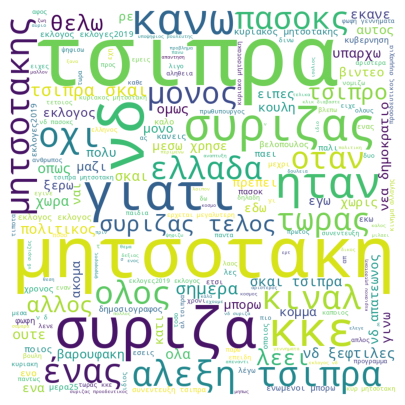

In [30]:
wordcloud = WordCloud(width=800, height=800,background_color='white').generate(' '.join(train_set['Text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Token Frequency

In [31]:
tokens = ' '.join(train_set['Text']).split()
token_counts = Counter(tokens)
print(token_counts.most_common(10))

[('τσιπρα', 9690), ('νδ', 8170), ('μητσοτακη', 7005), ('εκλογος', 4325), ('συριζας', 4189), ('κκε', 3525), ('συριζα', 3401), ('2019', 3164), ('σκαι', 2943), ('μητσοτακης', 2254)]


Text Length Distribution

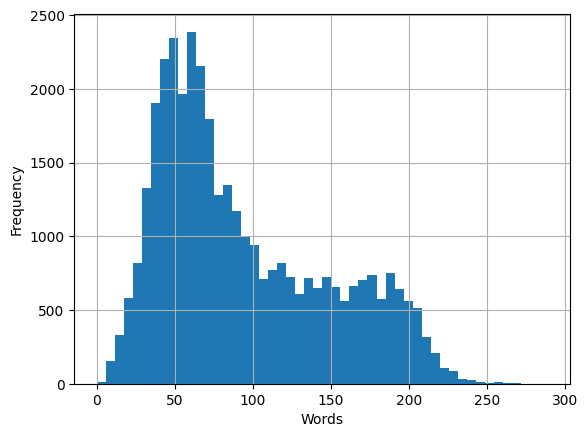

In [32]:
df = train_set.copy()

df['Text'] = df['Text'].apply(len)
df['Text'].hist(bins=50)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

Vectorization and Label Encoding

In [106]:
vectorizer = CountVectorizer()
encoder = LabelEncoder()

#Transform datasets
X_train_transformed = vectorizer.fit_transform(train_set['Text'])
X_brute = vectorizer.transform(bruteforce_set['Text'])
X_test = vectorizer.transform(test_set['Text'])

#Transform labels
Y_train_transformed = encoder.fit_transform(train_set['Sentiment'])
Y_brute  = encoder.transform(bruteforce_set['Sentiment'])

#Create dictionary with the corresponding values of the label encoding
print(encoder.classes_)
print(encoder.transform(encoder.classes_))
labels = {0 : 'NEGATIVE',1 : 'NEUTRAL',2 : 'POSITIVE'}


['NEGATIVE' 'NEUTRAL' 'POSITIVE']
[0 1 2]


Brute Force Run

In [34]:
X_train, X_val, Y_train, Y_val = train_test_split(X_brute, Y_brute, test_size=0.3)

classifier = LogisticRegression(max_iter=2000,C=1.0,multi_class='auto',solver='lbfgs',tol=1e-4)
classifier.fit(X_train, np.ravel(Y_train))

results_train = classifier.predict(X_train)

results = classifier.predict(X_val)

f1_train = f1_score(Y_train, results_train,average='weighted')
precision_train = precision_score(Y_train,results_train,average='weighted')
recall_train = recall_score(Y_train,results_train,average='weighted')

f1 = f1_score(Y_val, results,average='weighted')
precision = precision_score(Y_val, results,average='weighted')
recall = recall_score(Y_val, results,average='weighted')

print("F1 training score: " + str(f1_train))
print("F1 validation score: " + str(f1))
print("\n")
print("Recall training score: " + str(precision_train))
print("Recall validation score: " + str(precision))
print("\n")
print("Precision training score: " + str(recall_train))
print("Precision validation score: " + str(recall))

F1 training score: 0.5357156326629378
F1 validation score: 0.3610442761602099


Recall training score: 0.5423453493208147
Recall validation score: 0.36350344831571035


Precision training score: 0.5368355368355369
Precision validation score: 0.3639093639093639


Classification:

Average F1 training score: 0.7811889214491842
Average F1 validation score: 0.36068954469268577


Average Recall training score: 0.7812499498597433
Average Recall validation score: 0.3713440713440713


Average Precision training score: 0.7818120285162984
Average Precision validation score: 0.37170456118134915
Best F1 score: 0.3919237839277472


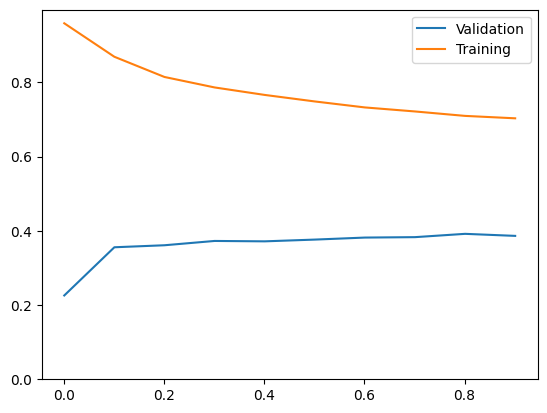

In [127]:
list_f1=[]
list_recall = []
list_precision = []
list_f1_train=[]
list_recall_train = []
list_precision_train = []
list_sample_size=[]

best_score = 0

X_train, X_val, Y_train, Y_val = train_test_split(X_train_transformed, Y_train_transformed, test_size=0.3)

for times in range(10):
  X, X_unused, y, y_unused = train_test_split(X_train, Y_train, test_size=1 - (times * 0.1 + 0.001))

  classifier = LogisticRegression(max_iter=2000,C=0.1,multi_class='auto',solver='lbfgs',tol=1e-3)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  results = classifier.predict(X_val)

  f1_train = f1_score(y, results_train,average='weighted')
  precision_train = precision_score(y,results_train,average='weighted')
  recall_train = recall_score(y,results_train,average='weighted')

  f1 = f1_score(Y_val, results,average='weighted')
  precision = precision_score(Y_val, results,average='weighted')
  recall = recall_score(Y_val, results,average='weighted')

  if f1 > best_score:
    best_score = f1
    best_model = classifier
  
  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_recall.append(recall)
  list_recall_train.append(recall_train)
  list_precision.append(precision)
  list_precision_train.append(precision_train)
  list_sample_size.append((times * 0.1 + 0.001))

plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

print("Average F1 training score: " + str(sum(list_f1_train) / len(list_f1_train)))
print("Average F1 validation score: " + str(sum(list_f1) / len(list_f1)))
print("\n")
print("Average Recall training score: " + str(sum(list_recall_train) / len(list_recall_train)))
print("Average Recall validation score: " + str(sum(list_recall) / len(list_recall)))
print("\n")
print("Average Precision training score: " + str(sum(list_precision_train) / len(list_precision_train)))
print("Average Precision validation score: " + str(sum(list_precision) / len(list_precision)))

print("Best F1 score: " + str(best_score))



Logistic Regression Classifier

$
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\text{Penalty} & \text{C} & \text{Multi Class} & \text{Max Iterations} & \text{Tolerance} & \text{Avg F1-Score}  & \text{Avg Recall-Score}  & \text{Avg Precision-Score} & \text{Best F1-Score}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{2000} & \text{0.0001} & \text{37.3\%} & \text{37.3\%} & \text{37.3\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{100} & \text{0.0001} & \text{35.4\%} & \text{36.2\%} & \text{36.4\%} & \text{37.2\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{500} & \text{0.0001} & \text{36.0\%} & \text{36.3\%} & \text{36.3\%} & \text{37.5\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{1000} & \text{0.0001} & \text{34.9\%} & \text{36.5\%} & \text{35.4\%} & \text{38.0\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{2000} & \text{0.0001} & \text{35.7\%} & \text{36.3\%} & \text{36.4\%} & \text{37.7\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{4000} & \text{0.0001} & \text{34.6\%} & \text{36.3\%} & \text{35.8\%} & \text{37.6\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{500} & \text{0.0001} & \text{35.7\%} & \text{37.0\%} & \text{36.0\%} & \text{38.2\%}\\
\hline
\text{L2} & \text{5.0} & \text{auto} & \text{500} & \text{0.0001} & \text{35.5\%} & \text{36.1\%} & \text{36.1\%} & \text{37.1\%}\\
\hline
\text{L2} & \text{5.0} & \text{auto} & \text{2000} & \text{0.0001} & \text{35.5\%} & \text{36.1\%} & \text{36.2\%} & \text{37.4\%}\\
\hline
\text{L2} & \text{10.0} & \text{auto} & \text{2000} & \text{0.0001} & \text{34.7\%} & \text{35.8\%} & \text{35.7\%} & \text{36.6\%}\\
\hline
\text{L2} & \text{20.0} & \text{auto} & \text{2000} & \text{0.0001} & \text{34.8\%} & \text{35.8\%} & \text{35.8\%} & \text{36.8\%}\\
\hline
\text{L2} & \text{100.0} & \text{auto} & \text{2000} & \text{0.0001} & \text{34.3\%} & \text{35.6\%} & \text{35.5\%} & \text{36.2\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{2000} & \text{0.0001} & \text{35.8\%} & \text{36.6\%} & \text{35.5\%} & \text{38.0\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{2000} & \text{0.01} & \text{35.2\%} & \text{36.9\%} & \text{35.7\%} & \text{38.0\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{2000} & \text{0.001} & \text{36.0\%} & \text{37.1\%} & \text{37.1\%} & \text{39.2\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{2000} & \text{0.00001} & \text{36.9\%} & \text{37.0\%} & \text{37.0\%} & \text{38.0\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{2000} & \text{0.000001} & \text{35.4\%} & \text{36.5\%} & \text{35.6\%} & \text{37.4\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{2000} & \text{0.0000001} & \text{35.3\%} & \text{36.8\%} & \text{36.6\%} & \text{37.8\%}\\
\hline
\end{array}
$


Predict Test Set

In [128]:
#Predict the labels for the test set
y_pred = best_model.predict(X_test)

#Create a dataframe based on a dictionary of the IDs and the predictions
y_test = pd.DataFrame(data={'Id': test_set['New_ID'], 'Predicted': y_pred})

#Convert the predicted labels [0,1,2] back to their corresponding labels [NEGATIVE,NEUTRAL,POSITIVE]
y_test['Predicted'] = y_test['Predicted'].apply(lambda x: labels.get(x,x))

#Save as csv
y_test.to_csv('sumbission.csv',index=False)
